# **EDA Images**

**Course:** Master in Big Data, Data Science & AI — Master Thesis  
**Author:** Carlota Trigo La Blanca  

*This notebook will be used to do visualize some of the images from the database developed for my Master Thesis.*

## **Initialization**

In [1]:
# !pip install -q pandas pillow matplotlib fsspec gcsfs  # <- uncomment if needed

In [1]:
# Standard library
import os
import math
from pathlib import Path

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fsspec  # for gs://
from PIL import Image, ImageOps, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# --- FUNCTIONS ---
def resolve_local_path(row):
    """
    Devuelve una ruta de archivo existente para la imagen,
    probando: base/image_id, base/origin_dataset/image_id, y mismas con extensiones comunes.
    Además, si no hay extensión, hace un glob por el stem.
    """
    base = Path(IMAGES_BASE)
    img_id = (row.get("image_id") or "").strip()
    ds = (row.get("origin_dataset") or "").strip()

    if not img_id or img_id.lower() == "nan":
        return None

    stem, ext = os.path.splitext(img_id)
    candidates = []

    # Candidatos directos
    candidates.append(base / img_id)
    if ds:
        candidates.append(base / ds / img_id)

    # Si no hay extensión, prueba con las comunes
    if not ext:
        for e in COMMON_EXTS:
            candidates.append(base / f"{img_id}{e}")
            if ds:
                candidates.append(base / ds / f"{img_id}{e}")

        # Búsqueda por patrón (por si el id real es p.ej. 12345.JPG o 12345.png)
        for root in [base, base / ds] if ds else [base]:
            if root.is_dir():
                # Busca exactamente el stem con cualquier extensión
                matches = list(root.rglob(stem + ".*"))
                candidates.extend(matches)

    # Devuelve el primer candidato que exista como archivo
    for c in candidates:
        try:
            p = Path(c)
            if p.is_file():
                return str(p)
        except Exception:
            pass

    return None

def build_uri(row):
    # Para local, devolvemos la ruta resuelta (o None si no se encuentra)
    return resolve_local_path(row)

def open_image_any(uri):
    """Abre imagen desde gs://, http(s):// o ruta local y respeta orientación EXIF."""
    if not uri:
        return None
    s = str(uri)
    try:
        if s.startswith("gs://"):
            with fsspec.open(s, "rb") as f:
                im = Image.open(f)
                im = ImageOps.exif_transpose(im).convert("RGB")
                im.load()
                return im
        elif s.startswith("http://") or s.startswith("https://"):
            import requests, io
            r = requests.get(s, timeout=15)
            r.raise_for_status()
            im = Image.open(io.BytesIO(r.content))
            im = ImageOps.exif_transpose(im).convert("RGB")
            im.load()
            return im
        else:
            # <- Ruta local: NO usar open(...), pasar la ruta directamente
            im = Image.open(s)
            im = ImageOps.exif_transpose(im).convert("RGB")
            im.load()
            return im
    except Exception as e:
        print(f"[open_image_any] Falló {s} -> {type(e).__name__}: {e}")
        return None

In [5]:
# --- CONFIG ---
METADATA_CSV = "../data/metadata_clean.csv"
df = pd.read_csv(METADATA_CSV, delimiter=';')

IMAGES_BASE = "../data/images/images" 
COMMON_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

### Visualize an image per diagnostic

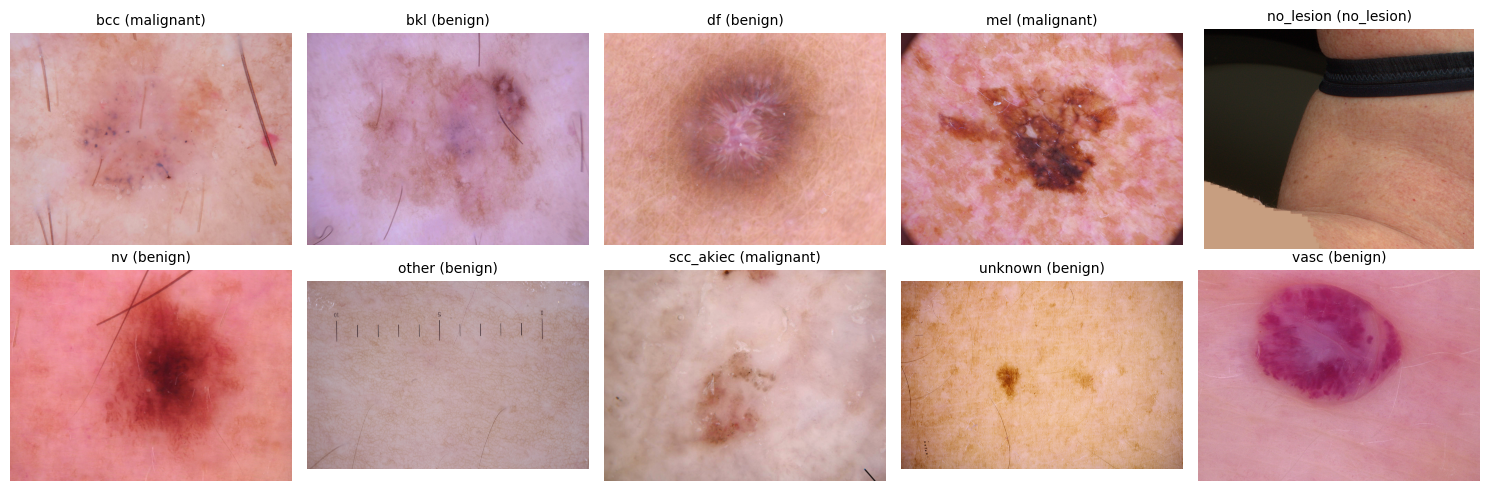

In [9]:
# --- Prepara muestra ---
tmp = df.dropna(subset=["diagnosis_grouped"]).copy()
tmp["img_uri"] = tmp.apply(build_uri, axis=1)

reps = (tmp.dropna(subset=["img_uri"])
           .sort_values(["diagnosis_grouped", "origin_dataset", "image_id"])
           .groupby("diagnosis_grouped", as_index=False)
           .nth(0)
           .reset_index(drop=True))

n = len(reps)
if n == 0:
    raise ValueError("No se encontró ninguna imagen en disco para las filas con diagnosis_grouped.")

# --- Plot ---
ncols = min(5, max(1, n))
nrows = math.ceil(n / ncols)

f, axes = plt.subplots(nrows, ncols, figsize=(15, 5))
axes = np.atleast_1d(axes).ravel()

for ax, (_, row) in zip(axes, reps.iterrows()):
    ax.axis("off")
    im = open_image_any(row["img_uri"])
    title = f"{row.get('diagnosis_grouped','')} ({row.get('lesion_type','')})"
    if im is None:
        ax.text(0.5, 0.5, "No se pudo abrir", ha="center", va="center", fontsize=10)
        ax.set_title(title, fontsize=10)
        print("[plot] No se pudo abrir:", row["img_uri"])
        continue
    ax.imshow(im)
    ax.set_title(title, fontsize=10)

for ax in axes[len(reps):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

outpath = r"C:\Users\msi\Desktop\tfm-ucm\figures\image_visualization.png"
f.savefig(outpath, bbox_inches='tight', pad_inches=0.02, dpi=300)